In [2]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

plt.rcParams["figure.figsize"] = (20,10)

/Users/josepsmachine/miniforge3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.has_mps, 'Mps not enabled'

# use the first gpu available if possible
device = torch.device("mps" if torch.has_mps else "cpu")
print(device)

mps


In [4]:
#@title The code in this cell defines a function to generate training and validation data, no need to worry about it. Just hit the play button before continuing { display-mode: "form" }
def generate_data(n_samples, generator, regression=False, noise_scale=2, **kwargs):

    if "noise" in kwargs:
        kwargs["noise"] *= noise_scale
    
    x_train, y_train = generator(n_samples, **kwargs) # training data

    x_val, y_val = generator(n_samples, **kwargs) # validation data

    # Plot the data
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title("Training Data") 
    ax[1].set_title("Validation Data")

    if regression:
        ax[0].scatter(x_train, y_train, cmap=plt.cm.coolwarm)
        ax[1].scatter(x_val, y_val, cmap=plt.cm.coolwarm)
    else:
        ax[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)
        ax[1].scatter(x_val[:, 0], x_val[:, 1], c=y_val, cmap=plt.cm.coolwarm)

    return x_train, y_train, x_val, y_val

In [6]:
#@title The code in this cell is just for visualization no need to worry about it. Just hit the play button before continuing { display-mode: "form" }
# Dont worry about the code in this cell it is just for visualization purposes you dont need to understand or edit it yet

def plot_model(x, y, model, axis):

    mesh = torch.arange(-2, 2, 0.01)

    xx, yy = torch.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        data = data.to(device) # move data to MPS device
        model = model.to(device) # move model to MPS device
        Z = model(data.detach()) # no need to use cuda() anymore
        #Z = model(data.cuda().detach())
    Z = Z.max(1)[1].reshape(xx.shape)
    axis.contourf(xx, yy, Z.cpu(), cmap=plt.cm.coolwarm, alpha=0.3)
    axis.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=y.cpu(), s=20, cmap=plt.cm.coolwarm)
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])


def plot_regressor(x, y, model, axis):
    
    x_min = torch.min(x.detach())
    x_max = torch.max(x.detach())
    x_range = torch.linspace(x_min, x_max, 100).unsqueeze(1).to(device)
        
    with torch.no_grad():
        y_pred = model(x_range).detach()
        
    axis.scatter(x.cpu(), y.cpu())
    axis.plot(x_range.cpu(), y_pred.cpu(), 'r-', lw=5, label="Model Prediction")
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    
def draw_plots(x, y, model, losses, visualize_surface = False, visualize_regressor = False):

    if visualize_surface and visualize_regressor:
        raise ValueError("Expected only one of 'visualize_error' or 'visualize_regressor' to be True.")

    if visualize_surface:
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title("Output Space")
        ax[1].set_title("Losses")
        ax[1].plot(losses["train"], label="training loss")
        ax[1].plot(losses["val"], label="validation loss")
        ax[1].set_xlabel("Epoch")
        plot_model(x, y, model, ax[0])
    
    elif visualize_regressor:
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title("Validation Data")
        ax[1].set_title("Losses")
        ax[1].plot(losses["train"], label="training loss")
        ax[1].plot(losses["val"], label="validation loss")
        ax[1].set_xlabel("Epoch")
        plot_regressor(x, y, model, ax[0])

    else:
        plt.plot(losses["train"], label="training loss")
        plt.plot(losses["val"], label="validation loss")
    
    plt.legend()
    plt.pause(0.000001)
    plt.show() 

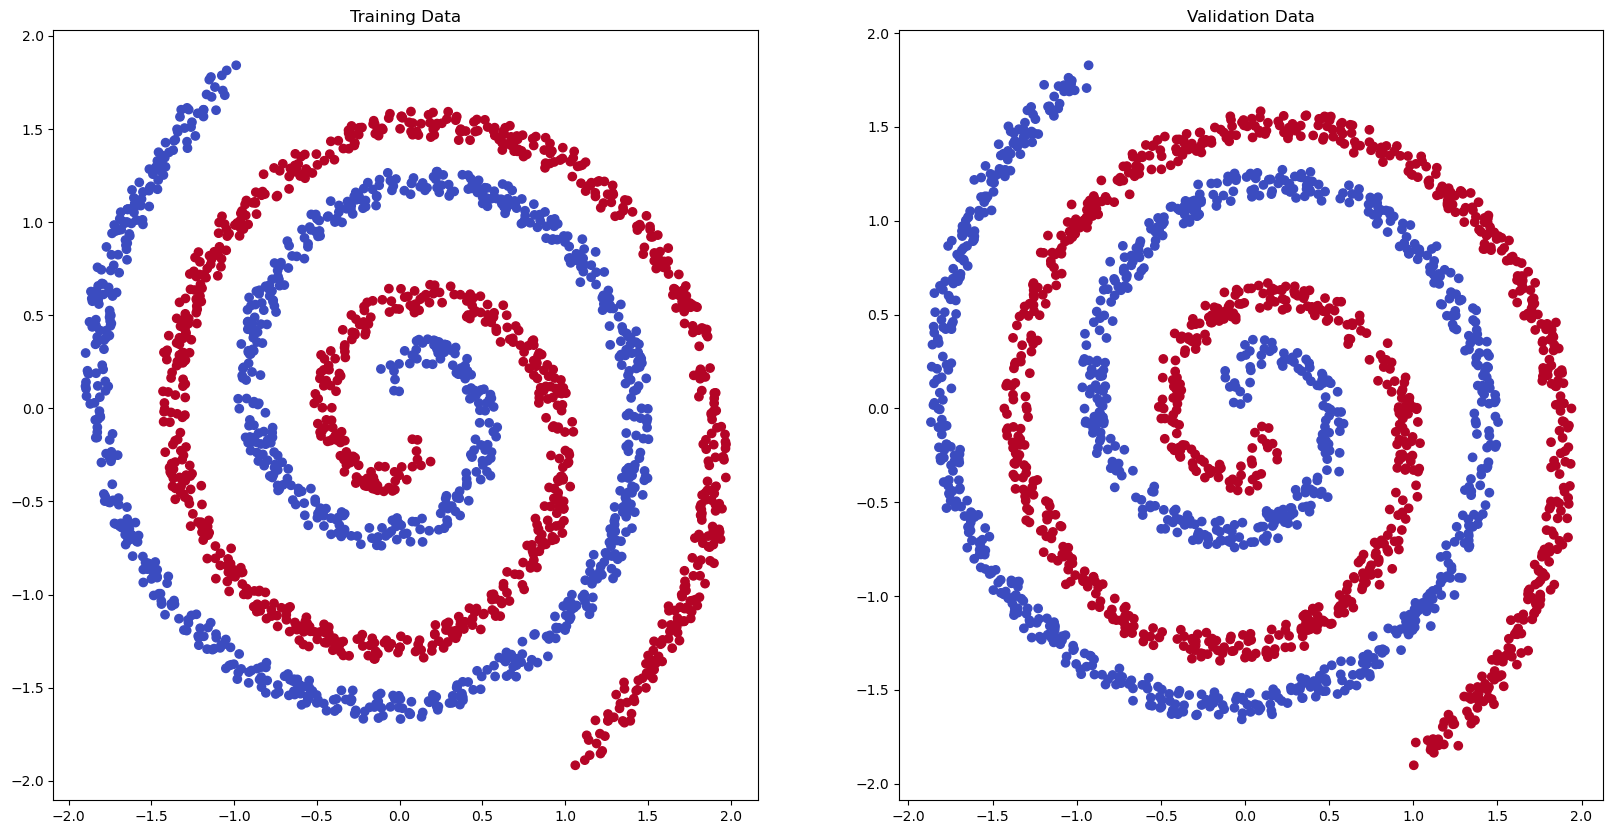

In [7]:
def make_spiral(n_points, noise=0.5):

    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points, 1) * noise

    x, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x + 1, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))).astype("int"))

    x = (x - x.mean()) / x.std()

    return x, y

N = 1000 # number of samples
xSpiralTrain, ySpiralTrain, xSpiralVal, ySpiralVal = generate_data(N, make_spiral, noise=0.5)

#Convert the data from numpy arrays into PyTorch tensors
xSpiralTrain = torch.from_numpy(xSpiralTrain).float()
ySpiralTrain = torch.from_numpy(ySpiralTrain).long()
xSpiralVal = torch.from_numpy(xSpiralVal).float()
ySpiralVal = torch.from_numpy(ySpiralVal).long()

# move data to gpu if available
xSpiralTrain = xSpiralTrain.to(device)
ySpiralTrain = ySpiralTrain.to(device)

xSpiralVal = xSpiralVal.to(device)
ySpiralVal = ySpiralVal.to(device)

In [128]:
# Your Code Here

import torch.nn as nn

class MoreComplexMLP(nn.Module):

    def __init__(self,input_dim,output_dim):
        super().__init__() #initialize parent class
        self.fc1 = nn.Linear(input_dim,100,dtype=torch.float32)
        self.fc2 = nn.Linear(100,50,dtype=torch.float32)
        self.fc3 = nn.Linear(50,10,dtype=torch.float32)
        self.fc_outp= nn.Linear(10,output_dim,dtype=torch.float32)

        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc2.bias)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        torch.nn.init.zeros_(self.fc3.bias)
        torch.nn.init.xavier_normal_(self.fc_outp.weight)
        torch.nn.init.zeros_(self.fc_outp.bias)
        
    
    def forward(self,x):
        out = self.fc1(x)
        out = torch.nn.functional.relu(out)
        out = self.fc2(out)
        out = torch.nn.functional.relu(out)
        out = self.fc3(out)
        out = torch.nn.functional.relu(out)
        return self.fc_outp(out)
    
modelComplex = MoreComplexMLP(input_dim=2,output_dim=2)

# move model to gpu if available
modelComplex.to(device)

MoreComplexMLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc_outp): Linear(in_features=10, out_features=2, bias=True)
)

In [129]:
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

In [130]:
learning_rate = 0.01
lambda_l2 = 1e-2

# we use the optim package to apply gradient descent for our parameter updates
optimizer = torch.optim.SGD(modelComplex.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

In [134]:
# Training loop
def train(x_train, y_train, x_val, y_val, criterion, model, optimizer, epochs=300, visualize_surface=False, visualize_regressor=False,lr=0.01):
    
    losses = {"train": [], "val": []} # Two lists to keep track of the evolution of our losses
    upd_lr = lr
    for t in range(epochs):
        # activate training mode
        model.train()
        
        # Feed forward to get the logits
        y_pred = model(x_train) # x_train is the whole batch, so we are doing full batch gradient descent here

        # Compute the loss
        loss = criterion(y_pred.squeeze(), y_train)
        
        # zero the gradients before running the backward pass
        optimizer.zero_grad()
        
        # Backward pass to compute the gradient of loss w.r.t our learnable params
        loss.backward()

        # Update params
        optimizer.step()

        model.eval() # we don't need gradients on to calculate performance, just simple inference
        
        # Compute the accuracy.
        score, predicted = torch.max(y_pred, dim=1) # torch.max() returns the maximum value and the argmax (index of the maximum value)
        train_acc = (y_train == predicted).sum().float() / len(y_train)
        losses["train"].append(loss.item() ) # keep track of our training loss

        # Run model on validation data
        val_loss, val_acc = calculateLossAcc(criterion, model, x_val, y_val) # Call our helper function (see below) on the validation set
        losses["val"].append(val_loss.item()) # keep track of our validation loss

        # Create plots
        display.clear_output(wait=True)
        draw_plots(x_val, y_val, model, losses, visualize_surface, visualize_regressor)

        print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))        
        print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))
        print(f"LEARNING_RATE: {upd_lr}")
        
        #update optimizer with new lr
        lenLosses = len(losses["train"])
        if lenLosses > 2:
            upd_lr = 10*(torch.sigmoid(loss)*lr).item() * torch.sigmoid(torch.tensor([1/(np.abs(np.gradient(losses["train"])[-1]))])).item() + 0.01

        optimizer = torch.optim.SGD(modelComplex.parameters(), lr=upd_lr, momentum=0.9, weight_decay=lambda_l2) # built-in L2

    return losses # In case we want to plot them afterwards

# A helper function that calculates our loss and accuracy on a given dataset (by default on our validation set)
def calculateLossAcc(criterion, model, x, y):

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x)


    # compute loss and accuracy 
    _, predicted = torch.max(y_pred, 1)
    loss = criterion(y_pred.squeeze(), y)
    acc = (y == predicted).sum().float() / len(y)

    return loss, acc

In [135]:
# You can set visualize_surface to False to omit the visualization of the output space. The training will be much faster this way

losses = train(xSpiralTrain, ySpiralTrain, xSpiralVal, ySpiralVal, criterion, modelComplex, optimizer, visualize_surface=True, epochs = 200,lr=learning_rate)

KeyboardInterrupt: 